20220920
Multilayer perceptron을 이용한 예측
- origin

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

import torch
print(torch.cuda.is_available())
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1, 2, 3"  # Set the GPUs 2 and 3 to use

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

import matplotlib.pyplot as plt

True
Device: cuda:1
Current cuda device: 0
Count of using GPUs: 4


In [2]:
%matplotlib inline

df = pd.read_csv('../data_up_delta.csv')
df.head()

,Unnamed: 0,receve comp time,printing start time,printing comp time,cutting start time,cutting comp time,pac time,T1,T2,T3,...,T5,X1,X2,X3,X4,Y0,X1_d1,X3_d1,X1_d2,X3_d2
0,2,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
1,3,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
2,4,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
3,5,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
4,6,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0


In [3]:
input_data = pd.DataFrame()
input_data[['receve comp time', 'X1','X2','X3', 'X4', 'X1_d1', 'X3_d1','Y0']] = df[['receve comp time', 'X1','X2','X3', 'X4', 'X1_d1', 'X3_d1', 'Y0']]
input_data.head(5)

,receve comp time,X1,X2,X3,X4,X1_d1,X3_d1,Y0
0,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
1,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
2,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
3,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
4,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0


In [4]:
# 데이터 프레임.info() 함수는 데이터프레임에 관한 정보
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16992 entries, 0 to 16991
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receve comp time  16992 non-null  object 
 1   X1                16992 non-null  float64
 2   X2                16992 non-null  float64
 3   X3                16992 non-null  float64
 4   X4                16992 non-null  float64
 5   X1_d1             16992 non-null  float64
 6   X3_d1             16992 non-null  float64
 7   Y0                16992 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.0+ MB


X1, X2, X3, X4 의 평균 구하기 추정할 때, 값이 없을 경우 평균으로 입력

In [5]:
X1_mean = df['X1'].mean()
X2_mean = df['X2'].mean()
X3_mean = df['X3'].mean()
X4_mean = df['X4'].mean()
Y0_mean = df['Y0'].mean()

X1_d1_mean = df['X1_d1'].mean()
X3_d1_mean = df['X3_d1'].mean()
print('X1 mean={:.2f}, X2 mean={:.2f}, X3 mean={:.2f}, X4 mean={:.2f}'.format(X1_mean, X2_mean, X3_mean, X4_mean))
print('X1_d1 mean={:.2f}, X3_d1 mean={:.2f}'.format(X1_d1_mean, X3_d1_mean))

X1 mean=123.99, X2 mean=5.05, X3 mean=130.89, X4 mean=10.54
X1_d1 mean=123.99, X3_d1 mean=130.89


In [6]:
# 데이터 셋을 target 기준으로 분리. Y0가 예측하려고 하는 값, X1, X2, X3 입력 변수 값
X = df[['X1','X2','X3', 'X4', 'X1_d1', 'X3_d1']].values
y = df['Y0'].values
print(X.shape, type(X))
print(y.shape, type(y))

(16992, 6) <class 'numpy.ndarray'>
(16992,) <class 'numpy.ndarray'>


In [7]:
# 80% training, 20% test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



(13593, 6) (13593,)
(3399, 6) (3399,)


데이터를 tensor 데이터형으로 변환

In [8]:
x_train_seq = torch.FloatTensor(x_train)
y_train_seq = torch.FloatTensor(y_train).view([-1, 1])
x_test_seq = torch.FloatTensor(x_test)
y_test_seq = torch.FloatTensor(y_test).view([-1, 1])
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([13593, 6]) torch.Size([13593, 1])
torch.Size([3399, 6]) torch.Size([3399, 1])


In [9]:
x_train_seq = x_train_seq.to(device)
y_train_seq = y_train_seq.to(device)
x_test_seq =  x_test_seq.to(device)
y_test_seq = y_test_seq.to(device)
print(x_train_seq.is_cuda)

True


data loader 만들기

In [10]:
# 배치 형태로 만들어 주자. 시계열이니까 셔플을 막 하면 안된다
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)  # x_train 과 y_train 은 하나의 TensorDataset 으로 결합
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader

모델 만들기

In [12]:
relu = nn.ReLU()
linear1 = nn.Linear(6, 64, bias=True)
linear2 = nn.Linear(64, 512, bias=True)
linear3 = nn.Linear(512, 1024, bias=True)
linear4 = nn.Linear(1024, 2048, bias=True)
linear5 = nn.Linear(2048, 4096, bias=True)
linear6 = nn.Linear(4096, 8192, bias=True)
linear7 = nn.Linear(8192, 2048, bias=True)
linear8 = nn.Linear(2048, 512, bias=True)
linear9 = nn.Linear(512, 32, bias=True)
linear10 = nn.Linear(32, 1, bias=True)

nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)
nn.init.xavier_uniform_(linear4.weight)
nn.init.xavier_uniform_(linear5.weight)
nn.init.xavier_uniform_(linear6.weight)
nn.init.xavier_uniform_(linear7.weight)
nn.init.xavier_uniform_(linear8.weight)
nn.init.xavier_uniform_(linear9.weight)
nn.init.xavier_uniform_(linear10.weight)

model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3, relu,
    linear4, relu,
    linear5, relu,
    linear6, relu,
    linear7, relu,
    linear8, relu,
    linear9, relu,
    linear10
)

print(model)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=8192, bias=True)
  (11): ReLU()
  (12): Linear(in_features=8192, out_features=2048, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2048, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)


In [13]:
model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=8192, bias=True)
  (11): ReLU()
  (12): Linear(in_features=8192, out_features=2048, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2048, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
import time
import os
import datetime
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


num_epochs = 2000
batch_size = 50
learning_r = 1e-3
pwd = os.getcwd()
print(pwd)
model_name = os.path.join(pwd,'model/mlp-data_up_delta4.model')
figure_name = os.path.join(pwd,'result/mlp-data_up_delta4.png')
print(model_name, figure_name)

def training(model, train_dataloader):
    print("\nTraining is Started ")
    model.train()
    criterion = nn.MSELoss()       
    optimizer = optim.Adam(model.parameters(), lr=learning_r)  

    start_time = time.time()
    loss_graph = [] # 그래프 그릴 목적인 loss.
    n = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.
        for data in train_loader:
            seq, target = data
            out = model(seq) 
            loss = criterion(out, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_graph.append(running_loss / n)
        if epoch % 10 == 0:
            print('[epoch: {}] loss: {:.4f}   Time: {}'.format(epoch, running_loss/n, datetime.datetime.now()))
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)
    plt.show()
    plt.savefig(figure_name)

    torch.save(model.state_dict(), model_name)
    print('    model_path={} is saved'.format(model_name))
    return


/sharehouse/DATA/SMART_FACTORY/ckim
/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-data_up_delta4.model /sharehouse/DATA/SMART_FACTORY/ckim/result/mlp-data_up_delta4.png


In [15]:
# err_range = 10.  # error range in hit ratio
def testing(model, test_loader, err_range): # all values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    print(test_pred[10:20])
    print(test_actual[10:20])
    
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [16]:
def testing2(model, test_loader, x2, x3, x4, x1_d1, x3_d1, err_range): # X1, All mean values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          seq[:,1] = x2
          seq[:,2] = x3
          seq[:,3] = x4
          seq[:,4] = x1_d1
          seq[:,5] = x3_d1
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [17]:
def testing3(model, test_loader, x2, x3, x4, x1_d1, x3_d1, err_range): # X1, X2 mean, X3 previous value, X4 mean / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
        
          #print(seq)
          seq[:,1] = x2
          seq[:,2] = seq[:, 1]
          seq[:,3] = x4
          #print('---> ', seq)
        
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

  0%|          | 0/2000 [00:00<?, ?it/s]


Training is Started 


  0%|          | 1/2000 [00:04<2:28:20,  4.45s/it]

[epoch: 0] loss: 72818.1857   Time: 2022-09-21 00:02:43.133340


  1%|          | 11/2000 [00:45<2:15:07,  4.08s/it]

[epoch: 10] loss: 15502.3418   Time: 2022-09-21 00:03:23.884037


  1%|          | 21/2000 [01:25<2:14:23,  4.07s/it]

[epoch: 20] loss: 592.1368   Time: 2022-09-21 00:04:04.625998


  2%|▏         | 31/2000 [02:06<2:13:42,  4.07s/it]

[epoch: 30] loss: 59.2903   Time: 2022-09-21 00:04:45.372194


  2%|▏         | 41/2000 [02:47<2:13:07,  4.08s/it]

[epoch: 40] loss: 1482.9460   Time: 2022-09-21 00:05:26.133610


  3%|▎         | 51/2000 [03:28<2:12:33,  4.08s/it]

[epoch: 50] loss: 26.2249   Time: 2022-09-21 00:06:06.936263


  3%|▎         | 61/2000 [04:09<2:11:53,  4.08s/it]

[epoch: 60] loss: 11.3502   Time: 2022-09-21 00:06:47.749476


  4%|▎         | 71/2000 [04:49<2:11:13,  4.08s/it]

[epoch: 70] loss: 1246.1739   Time: 2022-09-21 00:07:28.567975


  4%|▍         | 81/2000 [05:30<2:10:31,  4.08s/it]

[epoch: 80] loss: 50.7396   Time: 2022-09-21 00:08:09.374078


  5%|▍         | 91/2000 [06:11<2:09:51,  4.08s/it]

[epoch: 90] loss: 158.7822   Time: 2022-09-21 00:08:50.191467


  5%|▌         | 101/2000 [06:52<2:09:11,  4.08s/it]

[epoch: 100] loss: 406.5839   Time: 2022-09-21 00:09:31.008669


  6%|▌         | 111/2000 [07:33<2:08:31,  4.08s/it]

[epoch: 110] loss: 3610.8955   Time: 2022-09-21 00:10:11.828785


  6%|▌         | 121/2000 [08:13<2:07:48,  4.08s/it]

[epoch: 120] loss: 265.1600   Time: 2022-09-21 00:10:52.643814


  7%|▋         | 131/2000 [08:54<2:07:08,  4.08s/it]

[epoch: 130] loss: 6.2800   Time: 2022-09-21 00:11:33.460659


  7%|▋         | 141/2000 [09:35<2:06:32,  4.08s/it]

[epoch: 140] loss: 3.3958   Time: 2022-09-21 00:12:14.297598


  8%|▊         | 151/2000 [10:16<2:05:48,  4.08s/it]

[epoch: 150] loss: 4.6616   Time: 2022-09-21 00:12:55.126295


  8%|▊         | 161/2000 [10:57<2:05:08,  4.08s/it]

[epoch: 160] loss: 3.7728   Time: 2022-09-21 00:13:35.958145


  9%|▊         | 171/2000 [11:38<2:04:28,  4.08s/it]

[epoch: 170] loss: 8.1310   Time: 2022-09-21 00:14:16.787951


  9%|▉         | 181/2000 [12:18<2:03:50,  4.08s/it]

[epoch: 180] loss: 22.4597   Time: 2022-09-21 00:14:57.625287


 10%|▉         | 191/2000 [12:59<2:03:05,  4.08s/it]

[epoch: 190] loss: 12.6357   Time: 2022-09-21 00:15:38.454404


 10%|█         | 201/2000 [13:40<2:02:26,  4.08s/it]

[epoch: 200] loss: 4.7896   Time: 2022-09-21 00:16:19.284805


 11%|█         | 211/2000 [14:21<2:01:46,  4.08s/it]

[epoch: 210] loss: 2.0781   Time: 2022-09-21 00:17:00.120492


 11%|█         | 221/2000 [15:02<2:00:57,  4.08s/it]

[epoch: 220] loss: 330.8231   Time: 2022-09-21 00:17:40.919418


 12%|█▏        | 231/2000 [15:43<2:00:18,  4.08s/it]

[epoch: 230] loss: 11.7308   Time: 2022-09-21 00:18:21.722160


 12%|█▏        | 241/2000 [16:23<1:59:37,  4.08s/it]

[epoch: 240] loss: 19.5801   Time: 2022-09-21 00:19:02.524477


 13%|█▎        | 251/2000 [17:04<1:58:56,  4.08s/it]

[epoch: 250] loss: 108.9725   Time: 2022-09-21 00:19:43.328793


 13%|█▎        | 261/2000 [17:45<1:58:15,  4.08s/it]

[epoch: 260] loss: 62.0467   Time: 2022-09-21 00:20:24.131048


 14%|█▎        | 271/2000 [18:26<1:57:36,  4.08s/it]

[epoch: 270] loss: 1.4363   Time: 2022-09-21 00:21:04.938616


 14%|█▍        | 281/2000 [19:07<1:56:55,  4.08s/it]

[epoch: 280] loss: 1.5440   Time: 2022-09-21 00:21:45.759850


 15%|█▍        | 291/2000 [19:47<1:56:14,  4.08s/it]

[epoch: 290] loss: 375.9788   Time: 2022-09-21 00:22:26.576136


 15%|█▌        | 301/2000 [20:28<1:55:35,  4.08s/it]

[epoch: 300] loss: 2.1320   Time: 2022-09-21 00:23:07.392256


 16%|█▌        | 311/2000 [21:09<1:54:53,  4.08s/it]

[epoch: 310] loss: 2.9625   Time: 2022-09-21 00:23:48.202694


 16%|█▌        | 321/2000 [21:50<1:54:12,  4.08s/it]

[epoch: 320] loss: 4.6245   Time: 2022-09-21 00:24:29.016361


 17%|█▋        | 331/2000 [22:31<1:53:35,  4.08s/it]

[epoch: 330] loss: 19.4349   Time: 2022-09-21 00:25:09.851695


 17%|█▋        | 341/2000 [23:11<1:52:53,  4.08s/it]

[epoch: 340] loss: 3.9308   Time: 2022-09-21 00:25:50.679601


 18%|█▊        | 351/2000 [23:52<1:52:09,  4.08s/it]

[epoch: 350] loss: 475.4703   Time: 2022-09-21 00:26:31.506556


 18%|█▊        | 361/2000 [24:33<1:51:27,  4.08s/it]

[epoch: 360] loss: 6.7439   Time: 2022-09-21 00:27:12.317381


 19%|█▊        | 371/2000 [25:14<1:50:47,  4.08s/it]

[epoch: 370] loss: 14.2836   Time: 2022-09-21 00:27:53.125820


 19%|█▉        | 381/2000 [25:55<1:50:06,  4.08s/it]

[epoch: 380] loss: 1.2804   Time: 2022-09-21 00:28:33.931219


 20%|█▉        | 391/2000 [26:36<1:49:23,  4.08s/it]

[epoch: 390] loss: 245.2892   Time: 2022-09-21 00:29:14.728145


 20%|██        | 401/2000 [27:16<1:48:42,  4.08s/it]

[epoch: 400] loss: 90.1711   Time: 2022-09-21 00:29:55.525684


 21%|██        | 411/2000 [27:57<1:48:02,  4.08s/it]

[epoch: 410] loss: 21.6218   Time: 2022-09-21 00:30:36.319897


 21%|██        | 421/2000 [28:38<1:47:20,  4.08s/it]

[epoch: 420] loss: 137.3078   Time: 2022-09-21 00:31:17.107970


 22%|██▏       | 431/2000 [29:19<1:46:39,  4.08s/it]

[epoch: 430] loss: 4.2326   Time: 2022-09-21 00:31:57.898506


 22%|██▏       | 441/2000 [30:00<1:45:59,  4.08s/it]

[epoch: 440] loss: 44.3616   Time: 2022-09-21 00:32:38.696244


 23%|██▎       | 451/2000 [30:40<1:45:19,  4.08s/it]

[epoch: 450] loss: 15.5375   Time: 2022-09-21 00:33:19.485869


 23%|██▎       | 461/2000 [31:21<1:44:37,  4.08s/it]

[epoch: 460] loss: 385.6331   Time: 2022-09-21 00:34:00.275697


 24%|██▎       | 471/2000 [32:02<1:43:57,  4.08s/it]

[epoch: 470] loss: 460.3040   Time: 2022-09-21 00:34:41.073731


 24%|██▍       | 481/2000 [32:43<1:43:16,  4.08s/it]

[epoch: 480] loss: 5.0032   Time: 2022-09-21 00:35:21.868852


 25%|██▍       | 491/2000 [33:23<1:42:35,  4.08s/it]

[epoch: 490] loss: 12.5913   Time: 2022-09-21 00:36:02.661641


 25%|██▌       | 501/2000 [34:04<1:41:54,  4.08s/it]

[epoch: 500] loss: 71.4000   Time: 2022-09-21 00:36:43.452705


 26%|██▌       | 511/2000 [34:45<1:41:14,  4.08s/it]

[epoch: 510] loss: 45.2344   Time: 2022-09-21 00:37:24.242457


 26%|██▌       | 521/2000 [35:26<1:40:32,  4.08s/it]

[epoch: 520] loss: 2.6247   Time: 2022-09-21 00:38:05.030729


 27%|██▋       | 531/2000 [36:07<1:39:51,  4.08s/it]

[epoch: 530] loss: 290.1818   Time: 2022-09-21 00:38:45.823490


 27%|██▋       | 541/2000 [36:47<1:39:11,  4.08s/it]

[epoch: 540] loss: 74.4417   Time: 2022-09-21 00:39:26.633985


 28%|██▊       | 551/2000 [37:28<1:38:30,  4.08s/it]

[epoch: 550] loss: 2.1266   Time: 2022-09-21 00:40:07.415557


 28%|██▊       | 561/2000 [38:09<1:37:47,  4.08s/it]

[epoch: 560] loss: 31.5071   Time: 2022-09-21 00:40:48.190582


 29%|██▊       | 571/2000 [38:50<1:37:06,  4.08s/it]

[epoch: 570] loss: 5.8456   Time: 2022-09-21 00:41:28.969262


 29%|██▉       | 581/2000 [39:31<1:36:29,  4.08s/it]

[epoch: 580] loss: 54.7930   Time: 2022-09-21 00:42:09.758627


 30%|██▉       | 591/2000 [40:11<1:35:49,  4.08s/it]

[epoch: 590] loss: 10.3909   Time: 2022-09-21 00:42:50.553647


 30%|███       | 601/2000 [40:52<1:35:08,  4.08s/it]

[epoch: 600] loss: 39.9322   Time: 2022-09-21 00:43:31.363514


 31%|███       | 611/2000 [41:33<1:34:29,  4.08s/it]

[epoch: 610] loss: 1.6869   Time: 2022-09-21 00:44:12.176310


 31%|███       | 621/2000 [42:14<1:33:50,  4.08s/it]

[epoch: 620] loss: 1.1849   Time: 2022-09-21 00:44:52.987938


 32%|███▏      | 631/2000 [42:55<1:33:04,  4.08s/it]

[epoch: 630] loss: 1.2101   Time: 2022-09-21 00:45:33.776076


 32%|███▏      | 641/2000 [43:35<1:32:23,  4.08s/it]

[epoch: 640] loss: 1.3617   Time: 2022-09-21 00:46:14.571851


 33%|███▎      | 651/2000 [44:16<1:31:43,  4.08s/it]

[epoch: 650] loss: 2.4688   Time: 2022-09-21 00:46:55.375793


 33%|███▎      | 661/2000 [44:57<1:31:03,  4.08s/it]

[epoch: 660] loss: 32.5549   Time: 2022-09-21 00:47:36.173790


 34%|███▎      | 671/2000 [45:38<1:30:20,  4.08s/it]

[epoch: 670] loss: 386.4825   Time: 2022-09-21 00:48:16.973945


 34%|███▍      | 681/2000 [46:19<1:29:40,  4.08s/it]

[epoch: 680] loss: 75.1500   Time: 2022-09-21 00:48:57.767924


 35%|███▍      | 691/2000 [46:59<1:29:00,  4.08s/it]

[epoch: 690] loss: 1.4031   Time: 2022-09-21 00:49:38.558484


 35%|███▌      | 701/2000 [47:40<1:28:18,  4.08s/it]

[epoch: 700] loss: 35.4928   Time: 2022-09-21 00:50:19.352556


 36%|███▌      | 711/2000 [48:21<1:27:37,  4.08s/it]

[epoch: 710] loss: 46.8931   Time: 2022-09-21 00:51:00.145167


 36%|███▌      | 721/2000 [49:02<1:26:57,  4.08s/it]

[epoch: 720] loss: 60.7915   Time: 2022-09-21 00:51:40.937195


 37%|███▋      | 731/2000 [49:43<1:26:16,  4.08s/it]

[epoch: 730] loss: 1.1592   Time: 2022-09-21 00:52:21.730522


 37%|███▋      | 741/2000 [50:23<1:25:35,  4.08s/it]

[epoch: 740] loss: 1.9001   Time: 2022-09-21 00:53:02.526418


 38%|███▊      | 751/2000 [51:04<1:24:54,  4.08s/it]

[epoch: 750] loss: 14.1869   Time: 2022-09-21 00:53:43.319560


 38%|███▊      | 761/2000 [51:45<1:24:13,  4.08s/it]

[epoch: 760] loss: 1.3136   Time: 2022-09-21 00:54:24.108084


 39%|███▊      | 771/2000 [52:26<1:23:32,  4.08s/it]

[epoch: 770] loss: 11.1605   Time: 2022-09-21 00:55:04.896487


 39%|███▉      | 781/2000 [53:07<1:22:52,  4.08s/it]

[epoch: 780] loss: 28.5167   Time: 2022-09-21 00:55:45.685919


 40%|███▉      | 791/2000 [53:47<1:22:16,  4.08s/it]

[epoch: 790] loss: 124.8885   Time: 2022-09-21 00:56:26.487619


 40%|████      | 801/2000 [54:28<1:21:32,  4.08s/it]

[epoch: 800] loss: 1.4543   Time: 2022-09-21 00:57:07.292413


 41%|████      | 811/2000 [55:09<1:20:52,  4.08s/it]

[epoch: 810] loss: 1.3767   Time: 2022-09-21 00:57:48.103421


 41%|████      | 821/2000 [55:50<1:20:12,  4.08s/it]

[epoch: 820] loss: 11.1221   Time: 2022-09-21 00:58:28.919384


 42%|████▏     | 831/2000 [56:31<1:19:30,  4.08s/it]

[epoch: 830] loss: 1.2842   Time: 2022-09-21 00:59:09.729688


 42%|████▏     | 841/2000 [57:11<1:18:49,  4.08s/it]

[epoch: 840] loss: 6.3158   Time: 2022-09-21 00:59:50.548618


 43%|████▎     | 851/2000 [57:52<1:18:06,  4.08s/it]

[epoch: 850] loss: 5.1965   Time: 2022-09-21 01:00:31.351379


 43%|████▎     | 861/2000 [58:33<1:17:25,  4.08s/it]

[epoch: 860] loss: 34.3029   Time: 2022-09-21 01:01:12.136422


 44%|████▎     | 871/2000 [59:14<1:16:44,  4.08s/it]

[epoch: 870] loss: 2.8606   Time: 2022-09-21 01:01:52.918575


 44%|████▍     | 881/2000 [59:55<1:16:06,  4.08s/it]

[epoch: 880] loss: 13.9395   Time: 2022-09-21 01:02:33.726306


 45%|████▍     | 891/2000 [1:00:35<1:15:22,  4.08s/it]

[epoch: 890] loss: 33.5957   Time: 2022-09-21 01:03:14.506117


 45%|████▌     | 901/2000 [1:01:16<1:14:43,  4.08s/it]

[epoch: 900] loss: 5.0574   Time: 2022-09-21 01:03:55.286910


 46%|████▌     | 911/2000 [1:01:57<1:14:01,  4.08s/it]

[epoch: 910] loss: 1.7207   Time: 2022-09-21 01:04:36.072942


 46%|████▌     | 921/2000 [1:02:38<1:13:20,  4.08s/it]

[epoch: 920] loss: 58.2015   Time: 2022-09-21 01:05:16.860888


 47%|████▋     | 931/2000 [1:03:18<1:12:41,  4.08s/it]

[epoch: 930] loss: 7.4475   Time: 2022-09-21 01:05:57.653911


 47%|████▋     | 941/2000 [1:03:59<1:12:00,  4.08s/it]

[epoch: 940] loss: 146.0694   Time: 2022-09-21 01:06:38.449919


 48%|████▊     | 951/2000 [1:04:40<1:11:26,  4.09s/it]

[epoch: 950] loss: 9.7208   Time: 2022-09-21 01:07:19.293095


 48%|████▊     | 961/2000 [1:05:21<1:10:41,  4.08s/it]

[epoch: 960] loss: 71.5559   Time: 2022-09-21 01:08:00.107886


 49%|████▊     | 971/2000 [1:06:02<1:10:00,  4.08s/it]

[epoch: 970] loss: 1.7178   Time: 2022-09-21 01:08:40.930488


 49%|████▉     | 981/2000 [1:06:43<1:09:19,  4.08s/it]

[epoch: 980] loss: 2.8312   Time: 2022-09-21 01:09:21.756408


 50%|████▉     | 991/2000 [1:07:23<1:08:40,  4.08s/it]

[epoch: 990] loss: 68.6022   Time: 2022-09-21 01:10:02.582113


 50%|█████     | 1001/2000 [1:08:04<1:07:58,  4.08s/it]

[epoch: 1000] loss: 38.9993   Time: 2022-09-21 01:10:43.401405


 51%|█████     | 1011/2000 [1:08:45<1:07:17,  4.08s/it]

[epoch: 1010] loss: 2.3098   Time: 2022-09-21 01:11:24.229519


 51%|█████     | 1021/2000 [1:09:26<1:06:36,  4.08s/it]

[epoch: 1020] loss: 1.3407   Time: 2022-09-21 01:12:05.051492


 52%|█████▏    | 1031/2000 [1:10:07<1:05:54,  4.08s/it]

[epoch: 1030] loss: 176.4435   Time: 2022-09-21 01:12:45.862795


 52%|█████▏    | 1041/2000 [1:10:47<1:05:12,  4.08s/it]

[epoch: 1040] loss: 1.2393   Time: 2022-09-21 01:13:26.668846


 53%|█████▎    | 1051/2000 [1:11:28<1:04:32,  4.08s/it]

[epoch: 1050] loss: 1.5942   Time: 2022-09-21 01:14:07.475467


 53%|█████▎    | 1061/2000 [1:12:09<1:03:52,  4.08s/it]

[epoch: 1060] loss: 2.0208   Time: 2022-09-21 01:14:48.281140


 54%|█████▎    | 1071/2000 [1:12:50<1:03:10,  4.08s/it]

[epoch: 1070] loss: 25.2733   Time: 2022-09-21 01:15:29.082455


 54%|█████▍    | 1081/2000 [1:13:31<1:02:29,  4.08s/it]

[epoch: 1080] loss: 104.1809   Time: 2022-09-21 01:16:09.885229


 55%|█████▍    | 1091/2000 [1:14:12<1:01:48,  4.08s/it]

[epoch: 1090] loss: 3.1208   Time: 2022-09-21 01:16:50.687259


 55%|█████▌    | 1101/2000 [1:14:52<1:01:08,  4.08s/it]

[epoch: 1100] loss: 1.1139   Time: 2022-09-21 01:17:31.487611


 56%|█████▌    | 1111/2000 [1:15:33<1:00:27,  4.08s/it]

[epoch: 1110] loss: 180.1180   Time: 2022-09-21 01:18:12.284494


 56%|█████▌    | 1121/2000 [1:16:14<59:46,  4.08s/it]  

[epoch: 1120] loss: 161.9319   Time: 2022-09-21 01:18:53.085093


 57%|█████▋    | 1131/2000 [1:16:55<59:04,  4.08s/it]

[epoch: 1130] loss: 1.1608   Time: 2022-09-21 01:19:33.881145


 57%|█████▋    | 1141/2000 [1:17:35<58:23,  4.08s/it]

[epoch: 1140] loss: 36.7444   Time: 2022-09-21 01:20:14.667461


 58%|█████▊    | 1151/2000 [1:18:16<57:41,  4.08s/it]

[epoch: 1150] loss: 4.9750   Time: 2022-09-21 01:20:55.443425


 58%|█████▊    | 1161/2000 [1:18:57<57:03,  4.08s/it]

[epoch: 1160] loss: 1.2418   Time: 2022-09-21 01:21:36.243938


 59%|█████▊    | 1171/2000 [1:19:38<56:21,  4.08s/it]

[epoch: 1170] loss: 1.0912   Time: 2022-09-21 01:22:17.030011


 59%|█████▉    | 1181/2000 [1:20:19<55:40,  4.08s/it]

[epoch: 1180] loss: 1.1064   Time: 2022-09-21 01:22:57.822020


 60%|█████▉    | 1191/2000 [1:20:59<55:00,  4.08s/it]

[epoch: 1190] loss: 1.1613   Time: 2022-09-21 01:23:38.611467


 60%|██████    | 1201/2000 [1:21:40<54:19,  4.08s/it]

[epoch: 1200] loss: 1.8543   Time: 2022-09-21 01:24:19.406884


 61%|██████    | 1211/2000 [1:22:21<53:37,  4.08s/it]

[epoch: 1210] loss: 4.4633   Time: 2022-09-21 01:25:00.185651


 61%|██████    | 1221/2000 [1:23:02<52:58,  4.08s/it]

[epoch: 1220] loss: 189.4248   Time: 2022-09-21 01:25:40.980330


 62%|██████▏   | 1231/2000 [1:23:43<52:16,  4.08s/it]

[epoch: 1230] loss: 2.1148   Time: 2022-09-21 01:26:21.764534


 62%|██████▏   | 1241/2000 [1:24:23<51:35,  4.08s/it]

[epoch: 1240] loss: 2.0201   Time: 2022-09-21 01:27:02.551153


 63%|██████▎   | 1251/2000 [1:25:04<50:54,  4.08s/it]

[epoch: 1250] loss: 1.1269   Time: 2022-09-21 01:27:43.334093


 63%|██████▎   | 1261/2000 [1:25:45<50:14,  4.08s/it]

[epoch: 1260] loss: 7.6564   Time: 2022-09-21 01:28:24.124884


 64%|██████▎   | 1271/2000 [1:26:26<49:32,  4.08s/it]

[epoch: 1270] loss: 1.1266   Time: 2022-09-21 01:29:04.909369


 64%|██████▍   | 1281/2000 [1:27:07<48:52,  4.08s/it]

[epoch: 1280] loss: 37.8644   Time: 2022-09-21 01:29:45.699429


 65%|██████▍   | 1291/2000 [1:27:47<48:12,  4.08s/it]

[epoch: 1290] loss: 33.2851   Time: 2022-09-21 01:30:26.489508


 65%|██████▌   | 1301/2000 [1:28:28<47:31,  4.08s/it]

[epoch: 1300] loss: 7.0568   Time: 2022-09-21 01:31:07.276144


 66%|██████▌   | 1311/2000 [1:29:09<46:49,  4.08s/it]

[epoch: 1310] loss: 9.2100   Time: 2022-09-21 01:31:48.061285


 66%|██████▌   | 1321/2000 [1:29:50<46:11,  4.08s/it]

[epoch: 1320] loss: 32.8251   Time: 2022-09-21 01:32:28.882774


 67%|██████▋   | 1331/2000 [1:30:31<45:30,  4.08s/it]

[epoch: 1330] loss: 1.5341   Time: 2022-09-21 01:33:09.696566


 67%|██████▋   | 1341/2000 [1:31:11<44:49,  4.08s/it]

[epoch: 1340] loss: 1.8746   Time: 2022-09-21 01:33:50.507712


 68%|██████▊   | 1351/2000 [1:31:52<44:08,  4.08s/it]

[epoch: 1350] loss: 10.4541   Time: 2022-09-21 01:34:31.323731


 68%|██████▊   | 1361/2000 [1:32:33<43:27,  4.08s/it]

[epoch: 1360] loss: 1.6065   Time: 2022-09-21 01:35:12.131691


 69%|██████▊   | 1371/2000 [1:33:14<42:46,  4.08s/it]

[epoch: 1370] loss: 1.1666   Time: 2022-09-21 01:35:52.937428


 69%|██████▉   | 1381/2000 [1:33:55<42:06,  4.08s/it]

[epoch: 1380] loss: 1.1074   Time: 2022-09-21 01:36:33.750428


 70%|██████▉   | 1391/2000 [1:34:35<41:25,  4.08s/it]

[epoch: 1390] loss: 1.7526   Time: 2022-09-21 01:37:14.563295


 70%|███████   | 1401/2000 [1:35:16<40:44,  4.08s/it]

[epoch: 1400] loss: 1.4944   Time: 2022-09-21 01:37:55.370145


 71%|███████   | 1411/2000 [1:35:57<40:03,  4.08s/it]

[epoch: 1410] loss: 3.2572   Time: 2022-09-21 01:38:36.188226


 71%|███████   | 1421/2000 [1:36:38<39:23,  4.08s/it]

[epoch: 1420] loss: 172.0521   Time: 2022-09-21 01:39:17.006794


 72%|███████▏  | 1431/2000 [1:37:19<38:42,  4.08s/it]

[epoch: 1430] loss: 1.6880   Time: 2022-09-21 01:39:57.820524


 72%|███████▏  | 1441/2000 [1:37:59<38:01,  4.08s/it]

[epoch: 1440] loss: 6.5301   Time: 2022-09-21 01:40:38.636231


 73%|███████▎  | 1451/2000 [1:38:40<37:20,  4.08s/it]

[epoch: 1450] loss: 2.1663   Time: 2022-09-21 01:41:19.454331


 73%|███████▎  | 1461/2000 [1:39:21<36:40,  4.08s/it]

[epoch: 1460] loss: 21.8102   Time: 2022-09-21 01:42:00.273503


 74%|███████▎  | 1471/2000 [1:40:02<35:58,  4.08s/it]

[epoch: 1470] loss: 172.7899   Time: 2022-09-21 01:42:41.086946


 74%|███████▍  | 1481/2000 [1:40:43<35:18,  4.08s/it]

[epoch: 1480] loss: 114.8437   Time: 2022-09-21 01:43:21.911741


 75%|███████▍  | 1491/2000 [1:41:24<34:37,  4.08s/it]

[epoch: 1490] loss: 5.5621   Time: 2022-09-21 01:44:02.713319


 75%|███████▌  | 1501/2000 [1:42:04<33:55,  4.08s/it]

[epoch: 1500] loss: 1.4665   Time: 2022-09-21 01:44:43.512246


 76%|███████▌  | 1511/2000 [1:42:45<33:14,  4.08s/it]

[epoch: 1510] loss: 303.6337   Time: 2022-09-21 01:45:24.309389


 76%|███████▌  | 1521/2000 [1:43:26<32:34,  4.08s/it]

[epoch: 1520] loss: 1.5591   Time: 2022-09-21 01:46:05.105892


 77%|███████▋  | 1531/2000 [1:44:07<31:53,  4.08s/it]

[epoch: 1530] loss: 1.1664   Time: 2022-09-21 01:46:45.900804


 77%|███████▋  | 1541/2000 [1:44:48<31:12,  4.08s/it]

[epoch: 1540] loss: 4.5731   Time: 2022-09-21 01:47:26.705013


 78%|███████▊  | 1551/2000 [1:45:28<30:30,  4.08s/it]

[epoch: 1550] loss: 3.7682   Time: 2022-09-21 01:48:07.485487


 78%|███████▊  | 1561/2000 [1:46:09<29:50,  4.08s/it]

[epoch: 1560] loss: 20.2880   Time: 2022-09-21 01:48:48.269058


 79%|███████▊  | 1571/2000 [1:46:50<29:09,  4.08s/it]

[epoch: 1570] loss: 213.2357   Time: 2022-09-21 01:49:29.048112


 79%|███████▉  | 1581/2000 [1:47:31<28:28,  4.08s/it]

[epoch: 1580] loss: 6.9785   Time: 2022-09-21 01:50:09.823397


 80%|███████▉  | 1591/2000 [1:48:11<27:48,  4.08s/it]

[epoch: 1590] loss: 306.6722   Time: 2022-09-21 01:50:50.607494


 80%|████████  | 1601/2000 [1:48:52<27:07,  4.08s/it]

[epoch: 1600] loss: 8.6176   Time: 2022-09-21 01:51:31.388952


 81%|████████  | 1611/2000 [1:49:33<26:26,  4.08s/it]

[epoch: 1610] loss: 1.2109   Time: 2022-09-21 01:52:12.172233


 81%|████████  | 1621/2000 [1:50:14<25:45,  4.08s/it]

[epoch: 1620] loss: 116.2540   Time: 2022-09-21 01:52:52.958385


 82%|████████▏ | 1631/2000 [1:50:55<25:05,  4.08s/it]

[epoch: 1630] loss: 1.4668   Time: 2022-09-21 01:53:33.753136


 82%|████████▏ | 1641/2000 [1:51:35<24:24,  4.08s/it]

[epoch: 1640] loss: 26.2962   Time: 2022-09-21 01:54:14.554150


 83%|████████▎ | 1651/2000 [1:52:16<23:44,  4.08s/it]

[epoch: 1650] loss: 141.0399   Time: 2022-09-21 01:54:55.361264


 83%|████████▎ | 1661/2000 [1:52:57<23:03,  4.08s/it]

[epoch: 1660] loss: 130.7251   Time: 2022-09-21 01:55:36.153400


 84%|████████▎ | 1671/2000 [1:53:38<22:21,  4.08s/it]

[epoch: 1670] loss: 96.2267   Time: 2022-09-21 01:56:16.945743


 84%|████████▍ | 1681/2000 [1:54:19<21:41,  4.08s/it]

[epoch: 1680] loss: 135.4406   Time: 2022-09-21 01:56:57.744426


 85%|████████▍ | 1691/2000 [1:54:59<21:00,  4.08s/it]

[epoch: 1690] loss: 1.1864   Time: 2022-09-21 01:57:38.540438


 85%|████████▌ | 1701/2000 [1:55:40<20:20,  4.08s/it]

[epoch: 1700] loss: 1.7161   Time: 2022-09-21 01:58:19.363860


 86%|████████▌ | 1711/2000 [1:56:21<19:39,  4.08s/it]

[epoch: 1710] loss: 262.7743   Time: 2022-09-21 01:59:00.183955


 86%|████████▌ | 1721/2000 [1:57:02<18:59,  4.08s/it]

[epoch: 1720] loss: 1.9434   Time: 2022-09-21 01:59:41.027945


 87%|████████▋ | 1731/2000 [1:57:43<18:17,  4.08s/it]

[epoch: 1730] loss: 47.2820   Time: 2022-09-21 02:00:21.836502


 87%|████████▋ | 1741/2000 [1:58:23<17:36,  4.08s/it]

[epoch: 1740] loss: 21.1034   Time: 2022-09-21 02:01:02.648593


 88%|████████▊ | 1751/2000 [1:59:04<16:56,  4.08s/it]

[epoch: 1750] loss: 14.2210   Time: 2022-09-21 02:01:43.458069


 88%|████████▊ | 1761/2000 [1:59:45<16:15,  4.08s/it]

[epoch: 1760] loss: 1.7204   Time: 2022-09-21 02:02:24.264652


 89%|████████▊ | 1771/2000 [2:00:26<15:34,  4.08s/it]

[epoch: 1770] loss: 32.0960   Time: 2022-09-21 02:03:05.083976


 89%|████████▉ | 1781/2000 [2:01:07<14:54,  4.08s/it]

[epoch: 1780] loss: 2.8344   Time: 2022-09-21 02:03:45.907986


 90%|████████▉ | 1791/2000 [2:01:48<14:13,  4.08s/it]

[epoch: 1790] loss: 251.3143   Time: 2022-09-21 02:04:26.731597


 90%|█████████ | 1801/2000 [2:02:28<13:32,  4.08s/it]

[epoch: 1800] loss: 21.6903   Time: 2022-09-21 02:05:07.553282


 91%|█████████ | 1811/2000 [2:03:09<12:51,  4.08s/it]

[epoch: 1810] loss: 102.2942   Time: 2022-09-21 02:05:48.377397


 91%|█████████ | 1821/2000 [2:03:50<12:10,  4.08s/it]

[epoch: 1820] loss: 1.1494   Time: 2022-09-21 02:06:29.198490


 92%|█████████▏| 1831/2000 [2:04:31<11:29,  4.08s/it]

[epoch: 1830] loss: 5.0372   Time: 2022-09-21 02:07:10.017371


 92%|█████████▏| 1841/2000 [2:05:12<10:49,  4.08s/it]

[epoch: 1840] loss: 1.4311   Time: 2022-09-21 02:07:50.842909


 93%|█████████▎| 1851/2000 [2:05:52<10:08,  4.08s/it]

[epoch: 1850] loss: 1.4655   Time: 2022-09-21 02:08:31.670383


 93%|█████████▎| 1861/2000 [2:06:33<09:27,  4.08s/it]

[epoch: 1860] loss: 10.0532   Time: 2022-09-21 02:09:12.500829


 94%|█████████▎| 1871/2000 [2:07:14<08:46,  4.08s/it]

[epoch: 1870] loss: 5.5315   Time: 2022-09-21 02:09:53.300422


 94%|█████████▍| 1881/2000 [2:07:55<08:05,  4.08s/it]

[epoch: 1880] loss: 1.2574   Time: 2022-09-21 02:10:34.107855


 95%|█████████▍| 1891/2000 [2:08:36<07:24,  4.08s/it]

[epoch: 1890] loss: 194.9072   Time: 2022-09-21 02:11:14.897830


 95%|█████████▌| 1901/2000 [2:09:16<06:43,  4.08s/it]

[epoch: 1900] loss: 2.6291   Time: 2022-09-21 02:11:55.680639


 96%|█████████▌| 1911/2000 [2:09:57<06:02,  4.07s/it]

[epoch: 1910] loss: 18.7281   Time: 2022-09-21 02:12:36.320315


 96%|█████████▌| 1921/2000 [2:10:38<05:22,  4.08s/it]

[epoch: 1920] loss: 1.1250   Time: 2022-09-21 02:13:17.105824


 97%|█████████▋| 1931/2000 [2:11:19<04:41,  4.08s/it]

[epoch: 1930] loss: 32.2424   Time: 2022-09-21 02:13:57.886458


 97%|█████████▋| 1941/2000 [2:11:59<04:00,  4.08s/it]

[epoch: 1940] loss: 69.7577   Time: 2022-09-21 02:14:38.671940


 98%|█████████▊| 1951/2000 [2:12:40<03:19,  4.08s/it]

[epoch: 1950] loss: 19.9031   Time: 2022-09-21 02:15:19.459154


100%|█████████▉| 1991/2000 [2:15:23<00:36,  4.08s/it]

[epoch: 1990] loss: 8.8288   Time: 2022-09-21 02:18:02.596609


100%|██████████| 2000/2000 [2:16:00<00:00,  4.08s/it]


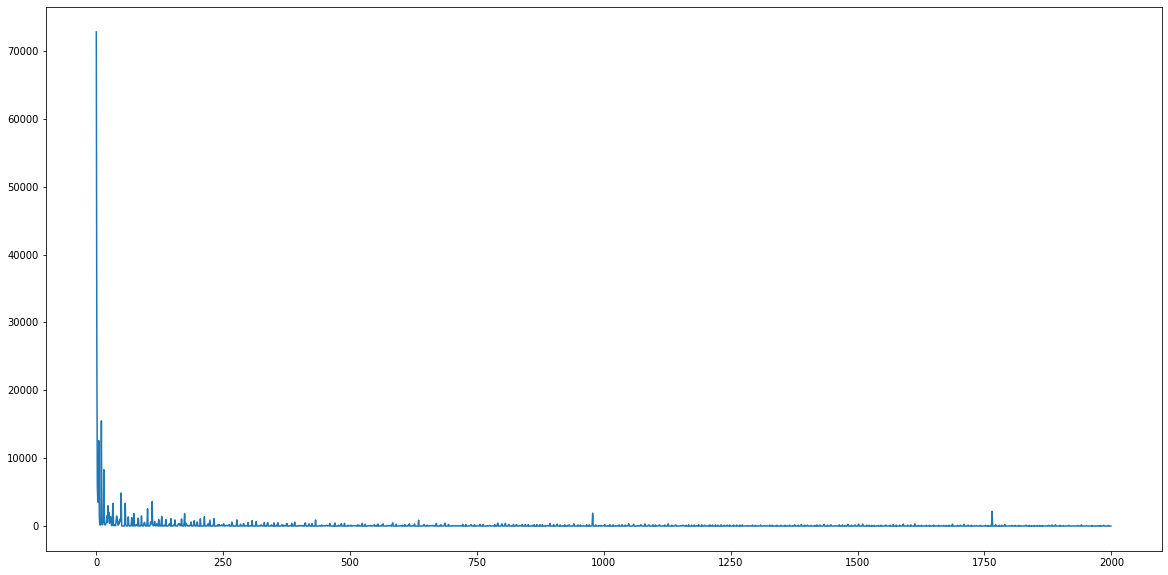

    model_path=/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-data_up_delta4.model is saved


<Figure size 432x288 with 0 Axes>

In [18]:
training(model, train_loader)

In [19]:
model.eval()

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=8192, bias=True)
  (11): ReLU()
  (12): Linear(in_features=8192, out_features=2048, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2048, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)

In [20]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [21]:
testing(model, test_loader, 10.)
testing(model, test_loader, 30.)


Testing is Started 
model is loaded
3399 3399
[[246.8733673095703], [107.70770263671875], [178.878662109375], [166.95457458496094], [1171.541015625], [560.4463500976562], [307.73809814453125], [105.90480041503906], [70.05828094482422], [85.95204162597656]]
[[247.0], [103.0], [179.0], [167.0], [1173.0], [560.0], [308.0], [106.0], [70.0], [86.0]]
평균제곱근오차 1.2096260660383409
결정계수 0.9999909611376803
hit ratio with error range(10.00) = 0.9997, no of errors = 1, total = 3399

Testing is Started 
model is loaded
3399 3399
[[246.8733673095703], [107.70770263671875], [178.878662109375], [166.95457458496094], [1171.541015625], [560.4463500976562], [307.73809814453125], [105.90480041503906], [70.05828094482422], [85.95204162597656]]
[[247.0], [103.0], [179.0], [167.0], [1173.0], [560.0], [308.0], [106.0], [70.0], [86.0]]
평균제곱근오차 1.2096260660383409
결정계수 0.9999909611376803
hit ratio with error range(30.00) = 0.9997, no of errors = 1, total = 3399


In [22]:
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 10.)
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 365.18084344002517
결정계수 -11.844014480546278
hit ratio with error range(10.00) = 0.0459, no of errors = 3243, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 365.18084344002517
결정계수 -11.844014480546278
hit ratio with error range(30.00) = 0.1294, no of errors = 2959, total = 3399


In [23]:
testing3(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 10.)
testing3(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 385.2140928298993
결정계수 -13.343031755625566
hit ratio with error range(10.00) = 0.1951, no of errors = 2736, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 385.2140928298993
결정계수 -13.343031755625566
hit ratio with error range(30.00) = 0.4169, no of errors = 1982, total = 3399


In [24]:
ran = [200, 400, 600, 800, 1000]
for i in ran:
    print(i, x_test[i], y_test[i])
    print(i-1, x_test[i-1], y_test[i-1])
    print('    mean = ', x_test[i-5:i].mean(axis=0))
print()


200 [112.   5.  18.  10. 118.  19.] 145.0
199 [320.   5. 412.  10. 320. 412.] 747.0
    mean =  [240.4   5.  235.6  10.  191.8 214.6]
400 [53.  5. 34. 10. 98. 63.] 102.0
399 [366.   5.  63.  10. 190.  81.] 444.0
    mean =  [187.2   5.   70.4  10.  172.  143.8]
600 [53.  5. 15. 10. 53. 15.] 83.0
599 [87.  5. 14. 10. 41. 15.] 116.0
    mean =  [111.    5.   52.4  10.  216.6  81.8]
800 [ 69.   5.  17.  10. 307.  79.] 101.0
799 [283.   5. 708.  10. 105.  16.] 1006.0
    mean =  [126.6   5.  184.4  10.   80.8 182.2]
1000 [140.   5.   3.  10.  52.  25.] 158.0
999 [281.   5. 297.  10.  92.  97.] 593.0
    mean =  [148.8   5.   86.8  10.   77.2  76.4]



Sample test

In [ ]:
X1_val = 169.
X2_val = 5.
X3_val = 13.
X4_val = 10.
Y0_val = 197.
X1_d1_val = 101.
X3_d1_val = 93.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
X1_d2_val = X1_d2_mean
X3_d2_val = X3_d2_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val, X1_d2_val, X3_d2_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])
X2_val = 5
X3_val = 18
X4_val = 10
X1_d1_val = 89
X3_d1_val = 18
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

In [39]:
X1_val = 29.
X2_val = 5.
X3_val = 28.
X4_val = 10.
Y0_val = 72.
X1_d1_val = 154.
X1_d2_val = 29.
X3_d1_val = 12.
X3_d2_val = 28.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 375.
X4_val = 10.
X1_d1_val = 48.
X3_d1_val = 57
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=29.00, X2=5.00, X3=28.00, X4=10.00, Y0=72.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [40]:
X1_val = 117.
X2_val = 5.
X3_val = 126.
X4_val = 10.
Y0_val = 258.
X1_d1_val = 76.
X3_d1_val = 17.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 105.
X4_val = 10.
X1_d1_val = 122.
X1_d2_val = 66.
X3_d1_val = 85.
X3_d2_val = 9.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=117.00, X2=5.00, X3=126.00, X4=10.00, Y0=258.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [41]:
X1_val = 95.
X2_val = 5.
X3_val = 6.
X4_val = 10.
Y0_val = 116.
X1_d1_val = 175.
X3_d1_val = 11.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val, X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 17.
X4_val = 10.
X1_d1_val = 167.
X3_d1_val = 17.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=95.00, X2=5.00, X3=6.00, X4=10.00, Y0=116.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [42]:
X1_val = 152.
X2_val = 5.
X3_val = 55.
X4_val = 10.
Y0_val = 222.
X1_d1_val = 282.
X3_d1_val = 259.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 55.
X4_val = 10.
X1_d1_val = 382.
X3_d1_val = 359.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=152.00, X2=5.00, X3=55.00, X4=10.00, Y0=222.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)